In [14]:
# ======================
# Setup & Imports
# ======================
import os, cv2, zipfile
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier


In [15]:
# Step 1: Unzip Dataset
# ======================
zip_path = "/content/dataset.zip"   # <- Upload dataset.zip to Colab
extract_path = "/content/dataset"

if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

print("Dataset extracted to:", extract_path)

Dataset extracted to: /content/dataset


In [16]:
# Path to face dataset folder (inside extracted zip)
dir_name = os.path.join(extract_path, "dataset", "faces")
if not os.path.exists(dir_name):
    raise FileNotFoundError(f"Expected folder {dir_name} not found. Please check zip structure.")


In [17]:
# ======================
# Utilities
# ======================
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(min(n_row * n_col, len(images))):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=9)
        plt.xticks(())
        plt.yticks(())
        plt.show()


In [18]:
# ======================
# Step 2: Load dataset
# ======================
y, x, target_names = [], [], []
person_id = 0
h = w = 300
n_samples = 0
class_names = []

for person_name in sorted(os.listdir(dir_name)):
    dir_path = os.path.join(dir_name, person_name)
    if not os.path.isdir(dir_path):
        continue
    class_names.append(person_name)
    for image_name in os.listdir(dir_path):
        image_path = os.path.join(dir_path, image_name)
        img = cv2.imread(image_path)
        if img is None:
            continue
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        resized_image = cv2.resize(gray, (h, w))
        v = resized_image.flatten()
        x.append(v)
        y.append(person_id)
        target_names.append(person_name)
        n_samples += 1
    person_id += 1

x = np.array(x)
y = np.array(y)
n_features = x.shape[1]
n_classes = len(class_names)

print("Total dataset size:")
print("n_samples:", n_samples)
print("n_features:", n_features)
print("n_classes:", n_classes)

Total dataset size:
n_samples: 450
n_features: 90000
n_classes: 9


In [19]:
# Step 3: Train/test split
# ======================
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.25, random_state=42, stratify=y
)


Extracting the top 150 eigenfaces from 337 faces


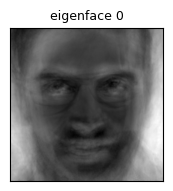

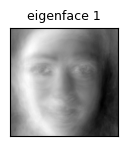

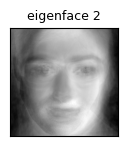

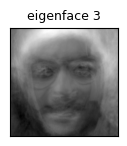

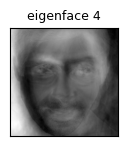

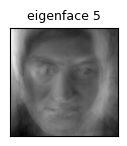

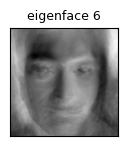

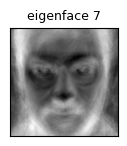

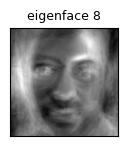

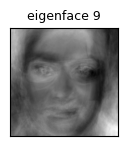

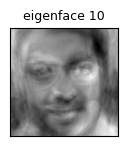

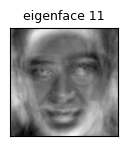

Projecting the input data on the eigenfaces orthonormal basis
Train PCA shape: (337, 150) Test PCA shape: (113, 150)


In [20]:
# Step 4: PCA (Eigenfaces)
# ======================
n_components = 150
print(f"Extracting the top {n_components} eigenfaces from {X_train.shape[0]} faces")

pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(X_train)
eigenfaces = pca.components_.reshape((n_components, h, w))

eigenface_titles = [f"eigenface {i}" for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)
plt.show()

print("Projecting the input data on the eigenfaces orthonormal basis")
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("Train PCA shape:", X_train_pca.shape, "Test PCA shape:", X_test_pca.shape)

In [21]:
# ======================
# Step 5: LDA (Fisherfaces)
# ======================
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_pca, y_train)
X_train_lda = lda.transform(X_train_pca)
X_test_lda = lda.transform(X_test_pca)
print("LDA projection done...")


LDA projection done...


In [28]:
# ======================
# Step 6: Classifier (MLP)
# ======================
clf = MLPClassifier(
    random_state=1,
    hidden_layer_sizes=(10, 10),
    max_iter=1000,
    verbose=True
).fit(X_train_lda, y_train)

print("Model weights:", [coef.shape for coef in clf.coefs_])

Iteration 1, loss = 3.12494912
Iteration 2, loss = 3.06249456
Iteration 3, loss = 3.00360765
Iteration 4, loss = 2.94916167
Iteration 5, loss = 2.89363203
Iteration 6, loss = 2.83992358
Iteration 7, loss = 2.78735161
Iteration 8, loss = 2.73638676
Iteration 9, loss = 2.68690508
Iteration 10, loss = 2.63782315
Iteration 11, loss = 2.59218810
Iteration 12, loss = 2.54568638
Iteration 13, loss = 2.50288879
Iteration 14, loss = 2.46037973
Iteration 15, loss = 2.41929136
Iteration 16, loss = 2.37952096
Iteration 17, loss = 2.34089681
Iteration 18, loss = 2.30321224
Iteration 19, loss = 2.26629633
Iteration 20, loss = 2.23108670
Iteration 21, loss = 2.19550905
Iteration 22, loss = 2.16245474
Iteration 23, loss = 2.12816986
Iteration 24, loss = 2.09666829
Iteration 25, loss = 2.06396178
Iteration 26, loss = 2.03251768
Iteration 27, loss = 2.00307910
Iteration 28, loss = 1.97307572
Iteration 29, loss = 1.94486752
Iteration 30, loss = 1.91633891
Iteration 31, loss = 1.88990864
Iteration 32, los

In [29]:
# ======================
# Step 7: Prediction
# ======================
y_pred, y_prob = [], []
for test_face in X_test_lda:
    prob = clf.predict_proba([test_face])[0]
    class_id = np.argmax(prob)
    y_pred.append(class_id)
    y_prob.append(np.max(prob))

y_pred = np.array(y_pred)

prediction_titles = []
true_positive = 0
for i in range(y_pred.shape[0]):
    true_name = class_names[y_test[i]]
    pred_name = class_names[y_pred[i]]
    result = f"pred: {pred_name}, pr: {y_prob[i]:.2f}\ntrue: {true_name}"
    prediction_titles.append(result)
    if true_name == pred_name:
        true_positive += 1

accuracy = true_positive * 100 / y_pred.shape[0]
print("Accuracy:", accuracy)


Accuracy: 69.91150442477876


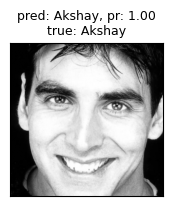

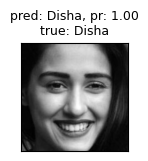

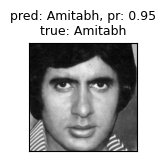

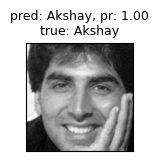

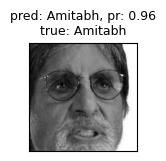

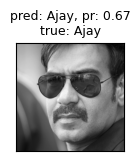

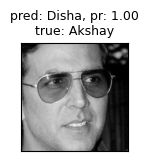

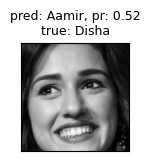

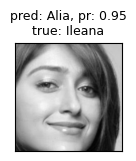

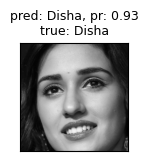

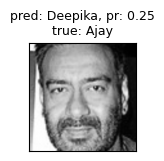

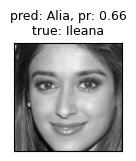

In [30]:
# Step 8: Plot results
# ======================
plot_gallery(X_test, prediction_titles, h, w)
plt.show()

In [32]:
# Step 8: Calculate accuracy for different k values
# ======================
k_values = [10, 20, 50, 100, 150, 200, 250, 300]
accuracies = []

print("Calculating accuracy for different k values...")
for k in k_values:
    print(f"Training with {k} components...")
    pca = PCA(n_components=k, svd_solver='randomized', whiten=True).fit(X_train)
    X_train_pca_k = pca.transform(X_train)
    X_test_pca_k = pca.transform(X_test)

    lda = LinearDiscriminantAnalysis()
    lda.fit(X_train_pca_k, y_train)
    X_train_lda_k = lda.transform(X_train_pca_k)
    X_test_lda_k = lda.transform(X_test_pca_k)

    clf = MLPClassifier(
        random_state=1,
        hidden_layer_sizes=(10, 10),
        max_iter=1000,
        verbose=False # Set verbose to False to avoid printing training progress for each k
    ).fit(X_train_lda_k, y_train)

    y_pred_k = clf.predict(X_test_lda_k)
    true_positive_k = np.sum(y_pred_k == y_test)
    accuracy_k = true_positive_k * 100 / y_pred_k.shape[0]
    accuracies.append(accuracy_k)
    print(f"Accuracy for k={k}: {accuracy_k:.2f}%")

print("Done calculating accuracies.")

Calculating accuracy for different k values...
Training with 10 components...


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy for k=10: 41.59%
Training with 20 components...


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy for k=20: 55.75%
Training with 50 components...


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy for k=50: 58.41%
Training with 100 components...
Accuracy for k=100: 63.72%
Training with 150 components...
Accuracy for k=150: 69.03%
Training with 200 components...
Accuracy for k=200: 69.03%
Training with 250 components...
Accuracy for k=250: 62.83%
Training with 300 components...
Accuracy for k=300: 17.70%
Done calculating accuracies.


In [33]:
# Step 9: Imposter detection
# ======================
# Define a simple threshold for low-confidence predictions
threshold = 0.6   # if max probability < 0.6, classify as "Imposter"

print("\n=== Imposter Detection ===")
y_pred_labels = []
for i in range(len(y_test)):
    if y_prob[i] < threshold:
        y_pred_labels.append("Imposter")
    else:
        y_pred_labels.append(class_names[y_pred[i]])

    print(f"Test {i+1}: True={class_names[y_test[i]]}, "
          f"Pred={y_pred_labels[-1]}, Confidence={y_prob[i]:.2f}")

# Count imposters
num_imposters = sum([1 for label in y_pred_labels if label == "Imposter"])
print(f"\nDetected {num_imposters} imposters out of {len(y_test)} test samples")


=== Imposter Detection ===
Test 1: True=Akshay, Pred=Akshay, Confidence=1.00
Test 2: True=Disha, Pred=Disha, Confidence=1.00
Test 3: True=Amitabh, Pred=Amitabh, Confidence=0.95
Test 4: True=Akshay, Pred=Akshay, Confidence=1.00
Test 5: True=Amitabh, Pred=Amitabh, Confidence=0.96
Test 6: True=Ajay, Pred=Ajay, Confidence=0.67
Test 7: True=Akshay, Pred=Disha, Confidence=1.00
Test 8: True=Disha, Pred=Imposter, Confidence=0.52
Test 9: True=Ileana, Pred=Alia, Confidence=0.95
Test 10: True=Disha, Pred=Disha, Confidence=0.93
Test 11: True=Ajay, Pred=Imposter, Confidence=0.25
Test 12: True=Ileana, Pred=Alia, Confidence=0.66
Test 13: True=Aamir, Pred=Ajay, Confidence=0.97
Test 14: True=Deepika, Pred=Ileana, Confidence=0.84
Test 15: True=Amitabh, Pred=Amitabh, Confidence=1.00
Test 16: True=Deepika, Pred=Deepika, Confidence=0.99
Test 17: True=Deepika, Pred=Deepika, Confidence=1.00
Test 18: True=Farhan, Pred=Imposter, Confidence=0.47
Test 19: True=Farhan, Pred=Farhan, Confidence=1.00
Test 20: True=